In [1]:
!pip install datasets
!pip install ckiptagger
!pip install rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
import os

from ckiptagger import WS, data_utils
from rouge import Rouge

cache_dir = os.environ.get("XDG_CACHE_HOME", os.path.join(os.getenv("HOME"), ".cache"))
download_dir = os.path.join(cache_dir, "ckiptagger")
data_dir = os.path.join(cache_dir, "ckiptagger/data")
os.makedirs(download_dir, exist_ok=True)
os.environ["TF_USE_LEGACY_KERAS"] = "1"
if not os.path.exists(os.path.join(data_dir, "model_ws")):
    data_utils.download_data_gdown(download_dir)

ws = WS(data_dir, disable_cuda=False)


def tokenize_and_join(sentences):
    return [" ".join(toks) for toks in ws(sentences)]


rouge = Rouge()


def get_rouge(preds, refs, avg=True, ignore_empty=False):
    """wrapper around: from rouge import Rouge
    Args:
        preds: string or list of strings
        refs: string or list of strings
        avg: bool, return the average metrics if set to True
        ignore_empty: bool, ignore empty pairs if set to True
    """
    if not isinstance(preds, list):
        preds = [preds]
    if not isinstance(refs, list):
        refs = [refs]
    preds, refs = tokenize_and_join(preds), tokenize_and_join(refs)
    return rouge.get_scores(preds, refs, avg=avg, ignore_empty=ignore_empty)

# Training

In [1]:
from transformers import AutoTokenizer, MT5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import json
import warnings
import logging
# from tw_rouge import get_rouge
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_data = json.loads(line)  # 將每一行轉換為JSON對象
            data.append(json_data)
    return data

data = read_jsonl("./train.jsonl")
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [2]:
checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = MT5ForConditionalGeneration.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [3]:
def preprocess_function(examples):
    # Tokenize the input (maintext) in batch
    model_inputs = tokenizer(examples["maintext"], max_length=256, truncation=True)

    # Tokenize the labels (title) in batch
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=64, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

In [4]:
# 對訓練和驗證數據進行預處理
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/17368 [00:00<?, ? examples/s]

Map:   0%|          | 0/4342 [00:00<?, ? examples/s]

In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Get ROUGE scores
    result = get_rouge(decoded_preds, decoded_labels)

    # Flattening the ROUGE result dictionary for rounding
    flat_result = {}
    for k, v in result.items():
        if isinstance(v, dict):
            for sub_k, sub_v in v.items():
                flat_result[f"{k}_{sub_k}"] = sub_v
        else:
            flat_result[k] = v

    # Calculate the average prediction length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    flat_result["gen_len"] = np.mean(prediction_lens)

    # Apply rounding to the flattened result
    return {k: round(v, 4) for k, v in flat_result.items()}

os.environ["WANDB_DISABLED"] = "true"
training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=2170,
    eval_steps=2170,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=10,
    predict_with_generate=True,
    disable_tqdm=False,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Rouge-1 R,Rouge-1 P,Rouge-1 F,Rouge-2 R,Rouge-2 P,Rouge-2 F,Rouge-l R,Rouge-l P,Rouge-l F,Gen Len
2170,4.878100,4.002358,0.159100,0.290400,0.196000,0.056500,0.102900,0.069200,0.146000,0.267900,0.180000,14.135400
4340,4.542600,3.824562,0.178900,0.283300,0.209800,0.063000,0.095500,0.072700,0.162400,0.258400,0.190700,16.576000
6510,4.358400,3.748001,0.185600,0.286000,0.215800,0.066100,0.097500,0.075700,0.168900,0.261600,0.196600,16.865000
8680,4.274700,3.712234,0.187300,0.284800,0.217000,0.067500,0.097700,0.076900,0.169800,0.259500,0.197000,17.064500
10850,4.247400,3.695209,0.188500,0.286000,0.218500,0.068200,0.098300,0.077600,0.171100,0.260600,0.198400,17.122800


TrainOutput(global_step=10850, training_loss=4.752330046622984, metrics={'train_runtime': 3319.9524, 'train_samples_per_second': 52.314, 'train_steps_per_second': 3.268, 'total_flos': 4.591450815725568e+16, 'train_loss': 4.752330046622984, 'epoch': 10.0})

In [9]:
trainer.save_model("./my_model")
tokenizer.save_pretrained("./my_model")

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/spiece.model',
 './my_model/added_tokens.json',
 './my_model/tokenizer.json')

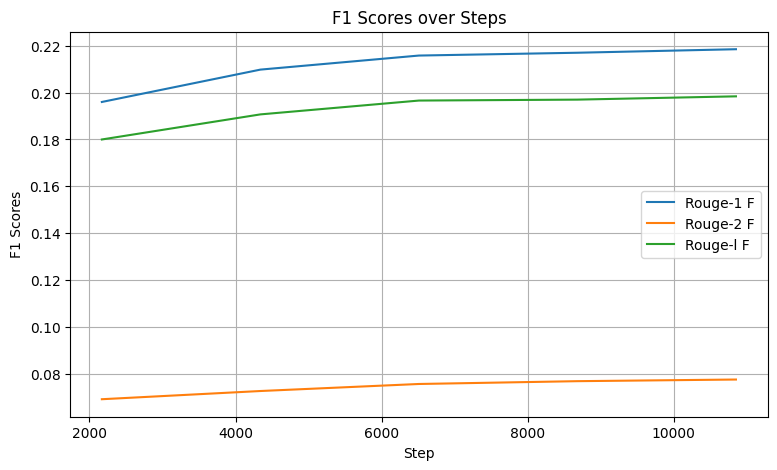

In [1]:
import matplotlib.pyplot as plt

r1_f = [0.1960, 0.2098, 0.2158, 0.2170, 0.2185]
r2_f = [0.0692, 0.0727, 0.0757, 0.0769, 0.0776]
rl_f = [0.1800, 0.1907, 0.1966, 0.1970, 0.1984]
steps = [2170, 4340, 6510, 8680, 10850]

plt.figure(figsize=(9, 5))
plt.plot(steps, r1_f, label='Rouge-1 F')
plt.plot(steps, r2_f, label='Rouge-2 F')
plt.plot(steps, rl_f, label='Rouge-l F')
plt.xlabel('Step')
plt.ylabel('F1 Scores')
plt.title('F1 Scores over Steps')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [10]:
model = MT5ForConditionalGeneration.from_pretrained("./my_model").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("./my_model")

In [12]:
test_data = read_jsonl("./public.jsonl")

def preprocess_function(examples):
    model_inputs = tokenizer(examples["maintext"], max_length=256, truncation=True, padding=True, return_tensors="pt")
    return model_inputs

# Convert test data to Dataset and preprocess
test_dataset = Dataset.from_pandas(pd.DataFrame(test_data))
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/5494 [00:00<?, ? examples/s]

In [31]:
from torch.utils.data import DataLoader

# Create DataLoader
collator = DataCollatorForSeq2Seq(tokenizer, model=model)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=16, collate_fn=collator)

# Generate predictions
def generate_predictions(batch):
    inputs = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)

    outputs = model.generate(
        input_ids=inputs,
        attention_mask=attention_mask,
        max_length=64,
        do_sample=True,   # 開啟 sampling
        # num_beams=5,
        temperature=1,
        top_k=10,
        top_p=0.95
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Batch-wise inference
predictions = []

for batch in tqdm(test_dataloader, desc="Generating predictions"):
    preds = generate_predictions(batch)
    predictions.extend(preds)

Generating predictions: 100%|██████████| 344/344 [03:16<00:00,  1.75it/s]


In [32]:
# Extract reference labels (true titles)
references = [example["title"] for example in test_data]

# Compute ROUGE scores using tw_rouge
rouge_result = get_rouge(predictions, references)

# Flattening the ROUGE result dictionary for better readability
flat_rouge_result = {}
for k, v in rouge_result.items():
    if isinstance(v, dict):
        for sub_k, sub_v in v.items():
            flat_rouge_result[f"{k}_{sub_k}"] = sub_v
    else:
        flat_rouge_result[k] = v

# Display the ROUGE results
for metric, score in flat_rouge_result.items():
    if "f" in metric.lower():
        print(f"{metric}: {score:.4f}")

rouge-1_f: 0.1960
rouge-2_f: 0.0636
rouge-l_f: 0.1757
